In [5]:
import tensorflow as tf
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [2]:
short_term_train = pd.read_csv("data/short_term_train.csv")
long_term_train = pd.read_csv("data/long_term_train.csv")
idx = short_term_train["Unnamed: 0"]
train_idx = idx.sample(frac=0.8, random_state=42)
test_idx = idx[~idx.isin(train_idx)]

In [19]:
def get_abdomen(image):
        img = np.array(image)
        # Check image shape before slicing
        if img.shape[0] == 128:
            return img[68:124, 36:92, :]
        elif img.shape[0] == 256:
            if img.shape[1] >= 240 and img.shape[2] == 3:
                return img[4:60, 4:60, :]
            else:
                raise ValueError("Image shape not suitable for expected slicing")
        else:
            raise ValueError("Unexpected image shape: {}".format(img.shape))
    

In [5]:
import pandas as pd
import h5py
from PIL import Image
from data_provider import prepare_for_triplet_loss

In [44]:
train_csv, valid_csv ="D:\ss24_seminarstatistic\data\long_term_train.csv","D:\ss24_seminarstatistic\data\long_term_valid.csv"
train_df = pd.read_csv(train_csv).sample(frac = 1,random_state=21)

train_df = prepare_for_triplet_loss(train_df, label="track_tag_id")
valid_df = pd.read_csv(valid_csv).sample(frac = 1,random_state=21)
valid_df = prepare_for_triplet_loss(valid_df, label="track_tag_id")

In [28]:
train_df[train_df["label"] == 1323]

,filename,label
16,uncensored_dataset/images/6_02_R_190723100000/...,1323
17,uncensored_dataset/images/9_02_R_190723130000/...,1323
56,uncensored_dataset/images/8_02_R_190723120000/...,1323
57,uncensored_dataset/images/13_02_R_190722170000...,1323
80,uncensored_dataset/images/10_02_R_190723140000...,1323
...,...,...
3589,uncensored_dataset/images/11_02_R_190723150000...,1323
3696,uncensored_dataset/images/64_02_R_190721180000...,1323
3697,uncensored_dataset/images/9_02_R_190723130000/...,1323
3698,uncensored_dataset/images/9_02_R_190723130000/...,1323


In [120]:
def get_abdomen(image):
    img = np.array(image)
    if img.shape[0] == 128:
        return img[68:124, 36:92,:]
    else:
        return img[16:240, 16:240,:]
    
def get_abdomen_large(image):
    img = np.array(image)
    if img.shape[0] == 256:
        return img[132:248, 85:171,:]
    else:
        return img[16:240, 16:240,:]

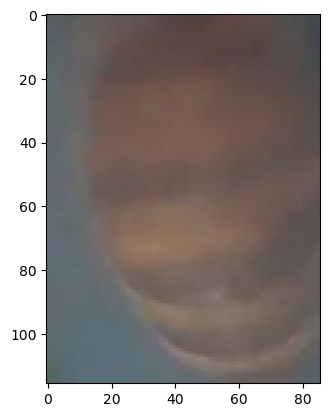

In [30]:
filename = train_df["filename"].values[1000]

img = Image.open(f"data/{filename}")
img = img.resize((256,256))
abdomen = get_abdomen_large(img)
plt.imshow(abdomen)

In [32]:
def create_h5(name, df):
    h5file = f"{name}.h5"

    nfiles_train = len(df["filename"])

    with h5py.File(h5file, "w") as h5f:
        img_ds = h5f.create_dataset("images",shape=(nfiles_train, 3,56,56))
        label_ds = h5f.create_dataset("label",shape=(nfiles_train))

        for cnt, ifile in enumerate(df["filename"]):

            img = Image.open(f"data/{ifile}")
            img = img.resize((128,128))
            abdomen = get_abdomen(img)
            if cnt%1000 == 0:
                print(cnt)
            abdomen = abdomen.transpose(2,0,1)
        
            img_ds[cnt:cnt+1:,:,:] = abdomen
            label_ds[cnt:cnt+1:] = df["label"].loc[cnt]

In [46]:
create_h5("long_term_train",train_df)
create_h5("long_term_val",valid_df)

0
1000
2000
3000
0
1000


In [30]:
from sklearn.model_selection import train_test_split

train_csv_short ="D:\ss24_seminarstatistic\data\short_term_train.csv"
df_short = pd.read_csv(train_csv_short)

tracks = df_short.label.unique()
train_tracks, val_tracks = train_test_split(tracks, test_size=0.2, random_state=42)
train_samples = df_short[df_short['label'].isin(train_tracks)]
val_samples = df_short[df_short['label'].isin(val_tracks)]

train_samples = train_samples.sample(frac = 1,random_state=42)
val_samples = val_samples.sample(frac = 1,random_state=42)


In [31]:
train_df_short = prepare_for_triplet_loss(train_samples, label="label")
val_df_short = prepare_for_triplet_loss(val_samples, label="label")
create_h5("short_term_train",train_df_short)
create_h5("short_term_val",val_df_short)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [36]:
import h5py
import numpy as np

def check_nan_in_h5_file(file_path):
    with h5py.File(file_path, "r") as db:
        # Check for NaN in "images"
        images_nan_indices = []
        for i in tqdm(range(db["images"].shape[0])):
            if np.isnan(db["images"][i]).any():
                images_nan_indices.append(i)
        
        # Check for NaN in "label"
        label_nan_indices = []
        for i in range(db["label"].shape[0]):
            if np.isnan(db["label"][i]).any():
                label_nan_indices.append(i)
        
        # Output the results
        if images_nan_indices:
            print(f"NaN found in 'images' at indices: {images_nan_indices}")
        else:
            print("No NaN found in 'images'")

        if label_nan_indices:
            print(f"NaN found in 'label' at indices: {label_nan_indices}")
        else:
            print("No NaN found in 'label'")

# Use the function with your file
check_nan_in_h5_file("short_term_train.h5")

100%|██████████| 86968/86968 [00:13<00:00, 6607.76it/s]


No NaN found in 'images'
No NaN found in 'label'


In [67]:
long_term_train_unshuffled = pd.read_csv("D:\ss24_seminarstatistic\data\long_term_train.csv")
long_term_val_unshuffled = pd.read_csv("D:\ss24_seminarstatistic\data\long_term_valid.csv")

In [68]:
long_term_train_unshuffled_df = prepare_for_triplet_loss(long_term_train_unshuffled, label="track_tag_id")
long_term_val_unshuffled_df  = prepare_for_triplet_loss(long_term_val_unshuffled, label="track_tag_id")
create_h5("long_term_train_unshuffled",long_term_train_unshuffled_df)
create_h5("long_term_val_unshuffled",long_term_val_unshuffled_df)

0
1000
2000
3000
0
1000


In [79]:
from dataset import H5Dataset
from torch.utils.data import DataLoader

train_dataset = H5Dataset(img_file="D:\ss24_seminarstatistic\\notebooks\long_term_train_unshuffled.h5")
train_loader = DataLoader(train_dataset, shuffle=False,batch_size=256, num_workers=6,persistent_workers=True)

In [7]:
from models import SimpleCNNv2Lightning
import pandas as pd


best_long_term_model = "D:\ss24_seminarstatistic\logs\lightning_logs\\version_106\checkpoints\epoch=146-step=2205.ckpt"
best_model = SimpleCNNv2Lightning.load_from_checkpoint(best_long_term_model)
n_distractors = 10

tsh_df = pd.read_csv("D:\ss24_seminarstatistic\data/test_same_hour.csv")
tsh_df = tsh_df[tsh_df.image_id < n_distractors + 2]
tsh_df = tsh_df[tsh_df.iteration_id ==0]
#tsh_ranks = random_eval_df(tsh_df,n_distractors=n_distractors)


In [8]:
from evaluation import filename2image_set
from torch.utils.data import DataLoader

def cmc_evaluation_df(model, df, image_size = (128,128), white=False, small_scale = False):
    """
    model: keras model
    df: a dataframe with the image to evaluate
    
    """
    queries_and_galleries = df.filename.values
    
    model.eval()   
    dataset = filename2image_set(queries_and_galleries, rescale_factor=4, image_size=image_size,num_workers=6,white=white,small_scale=small_scale)
        
    
    batch_size = 256
    dataloader= DataLoader(dataset, batch_size=batch_size,prefetch_factor=5,num_workers=6)
    model.eval()   
    predictions = []

    for batch in tqdm(dataloader):
        with torch.no_grad():
            predictions.append(model(batch))
        
    preds_l=[]
    #print(predictions[0].shape)
    for i in tqdm(range(0, len(predictions))):
        for j in range(0,predictions[i].cpu().numpy().shape[0]):
            preds_l.append(predictions[i][j].cpu().numpy())
    #print(i)
    #preds[i] = predictions[i].cpu()
    preds = np.array(preds_l)

    query_gallery_size = df.image_id.max() + 1
    n_distractors = query_gallery_size - 2
       
    galleries_per_iteraration = len(df.gallery_id.unique())
    iterations = df.iteration_id.max() + 1
    total_galleries =  galleries_per_iteraration * iterations
    
    queries_emb = preds[::query_gallery_size]
       
    pred_idx = np.arange(0, len(preds))
    galleries_emb = preds[np.mod(pred_idx, query_gallery_size) != 0]

    queries_emb = queries_emb.reshape(total_galleries, 1, -1)
    galleries_emb = galleries_emb.reshape(total_galleries, n_distractors + 1, -1 )

    # Calucluate distance
    cos_dist = tf.matmul(queries_emb, galleries_emb, transpose_b=True).numpy()
    euclid_dist = -(cos_dist - 1)
    print(euclid_dist.shape)
    # Calculate Rank
    r = np.argmin(np.argsort(euclid_dist), axis=2)
    
    r = np.squeeze(r)
    #print(r)
    ranks = np.zeros(n_distractors)
    for i in range(n_distractors):
        ranks[i] = np.mean(r < (i + 1))
    return r,euclid_dist

In [9]:
tsh_ranks, euclid_distance = cmc_evaluation_df(model=best_model, df=tsh_df, image_size=(128,128),white=False, small_scale = False)
non_zero = np.nonzero(tsh_ranks)

100%|██████████| 18/18 [00:00<00:00, 83.33it/s]


(380, 1, 11)


In [10]:
results = dict(zip(non_zero[0],tsh_ranks[non_zero[0]]))

best_sample = np.argmin((euclid_distance), axis=2)


In [13]:
wrong_classified_galleries = tsh_df[tsh_df["gallery_id"].isin(non_zero[0])]


anchors = []
samples_to_detect = []
false_sampled_images = []
for gallery_id in wrong_classified_galleries["gallery_id"].unique():
    gallery = wrong_classified_galleries[wrong_classified_galleries["gallery_id"] == gallery_id]
    print(gallery.shape)
    anchor = gallery[gallery["image_id"] == 0]
    sample_to_detect = gallery[gallery["image_id"] == 1] 
    false_sampled_image = gallery[gallery["image_id"] == best_sample[gallery_id][0]+1]
    anchors.append(anchor["filename"].values)
    samples_to_detect.append(sample_to_detect["filename"].values)
    false_sampled_images.append(false_sampled_image["filename"].values)


(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)
(12, 6)


In [14]:
df = pd.DataFrame({"anchor":anchors,"sample_to_detect":samples_to_detect,"false_sampled_image":false_sampled_images})


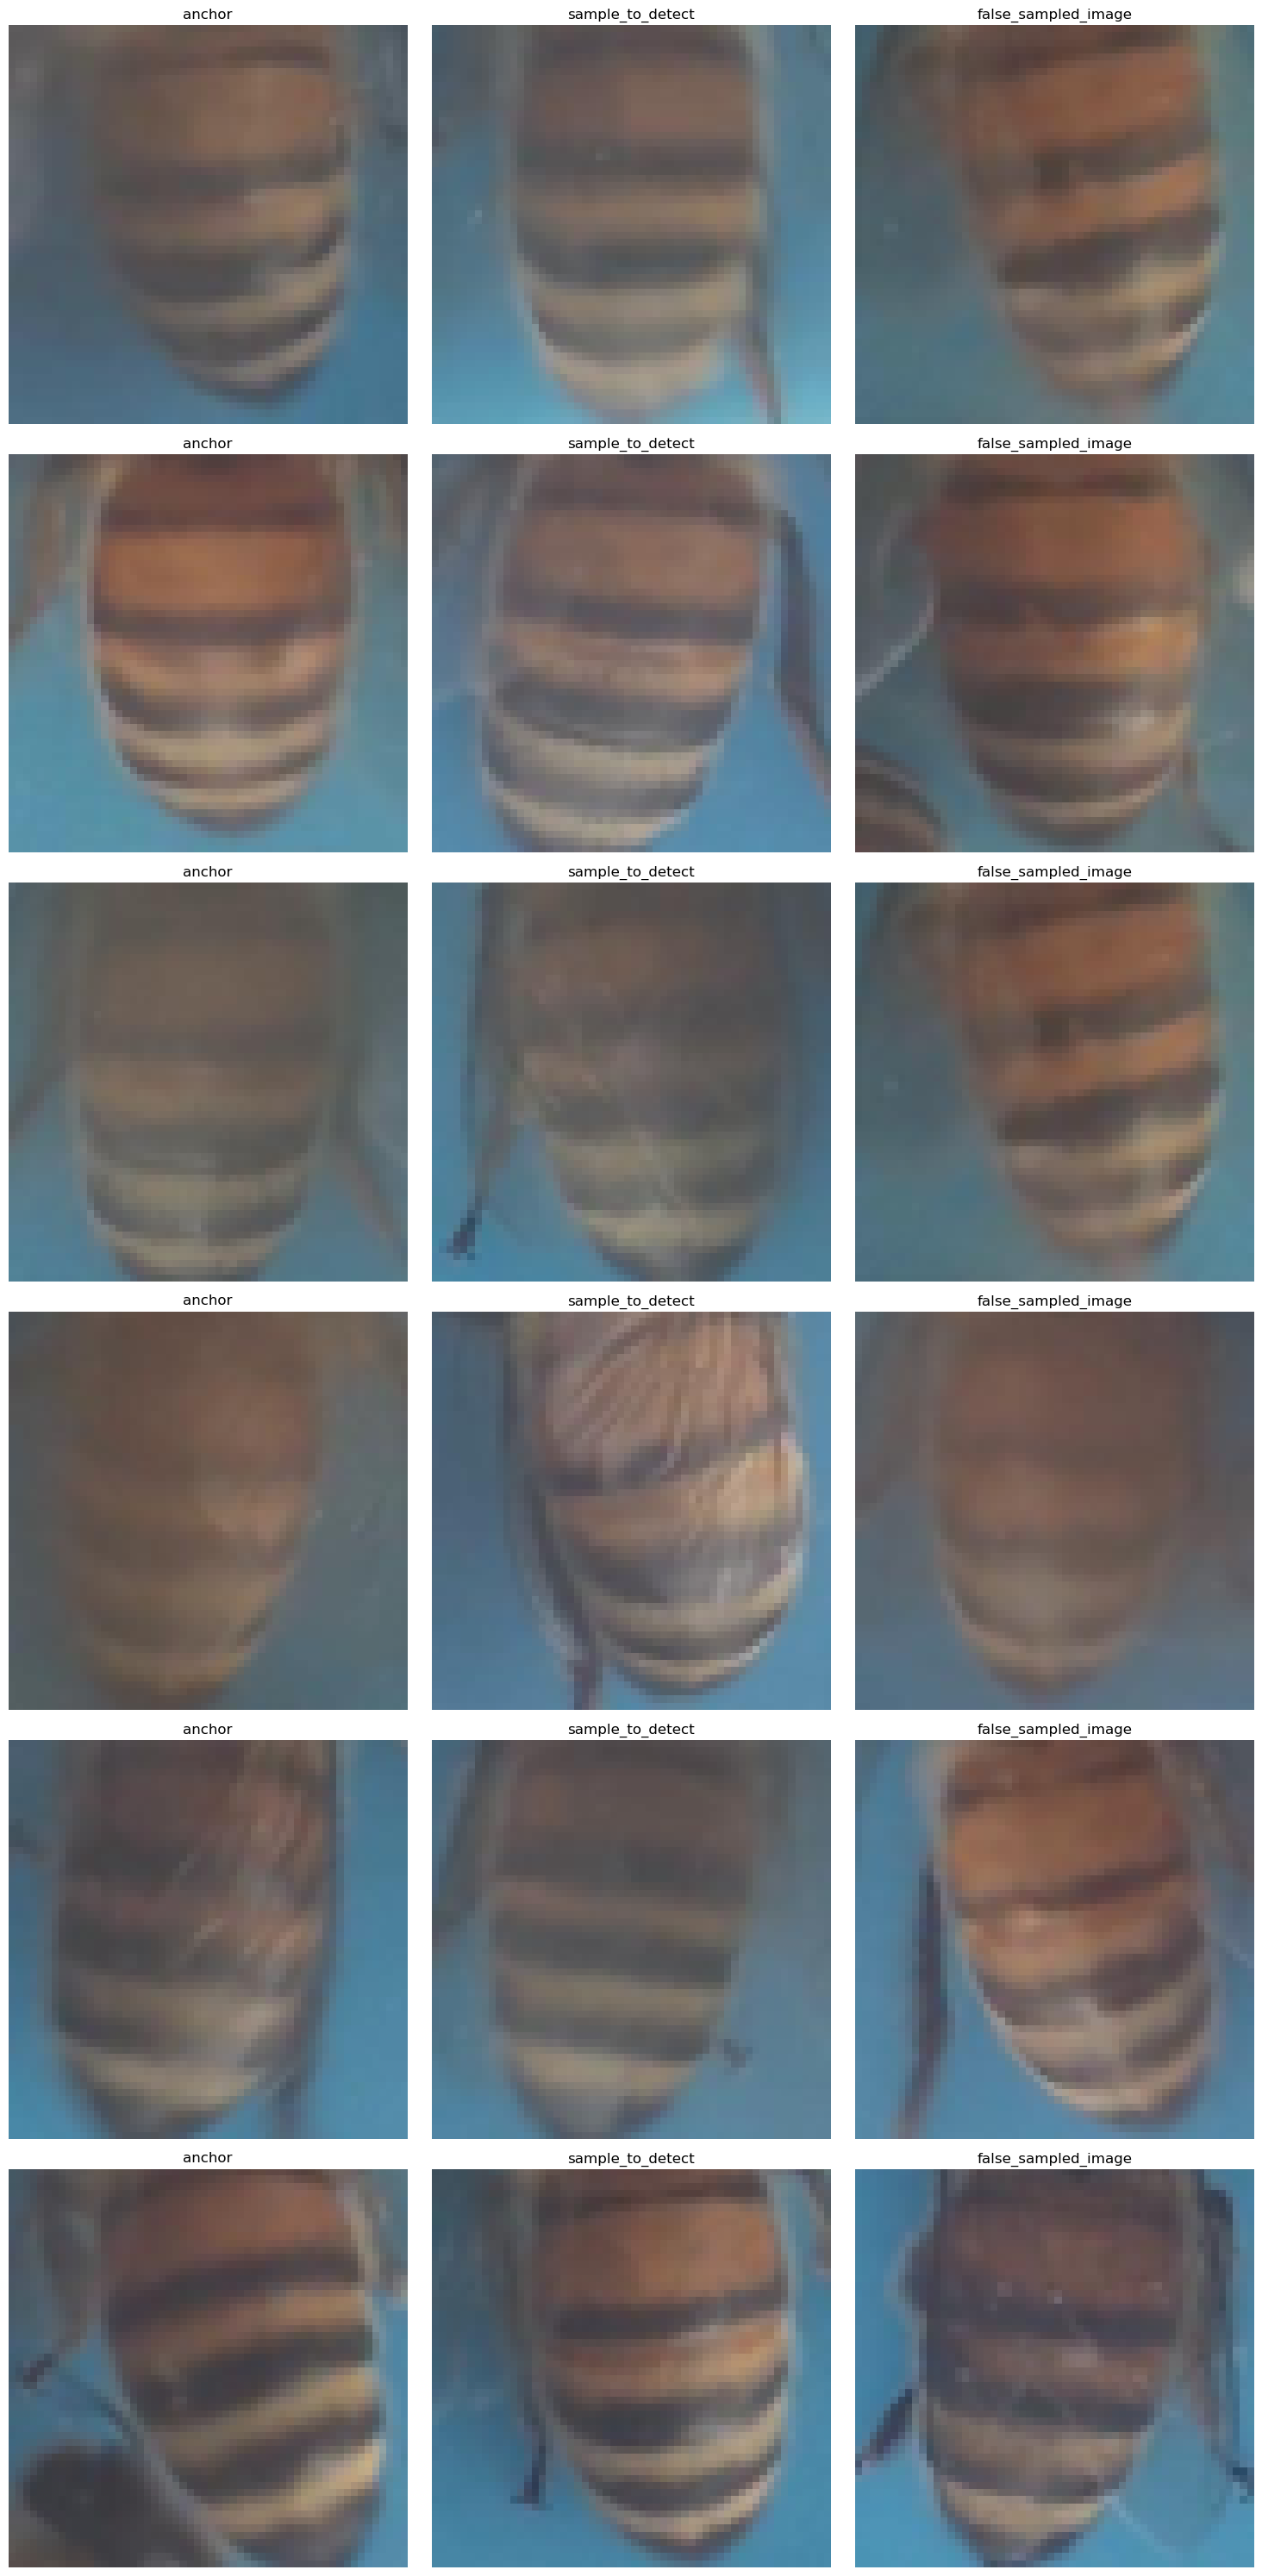

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

examples = df.sample(frac=0.06)

def display_images(df):
    num_rows = df.shape[0]
    num_cols = df.shape[1]

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    for i in range(num_rows):
        for j in range(num_cols):
            img_path = df.iloc[i, j]
            img = Image.open(f"data/{img_path[0]}")
            img = img.resize((128,128))
            abdomen = get_abdomen(img)
            axes[i, j].imshow(abdomen)
            axes[i, j].axis('off')  # Hide axes
            axes[i, j].set_title(df.columns[j])

    plt.tight_layout()
    plt.savefig("example_false_detections.jpg")
    plt.show()

# Call the function with your DataFrame
display_images(examples)
